In [1]:
import os
import tqdm
import random
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class
class TumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.image_names = []

        normal_dir = '/kaggle/input/wsidataset/normal/content/drive/MyDrive/Dataset/Normal'
        tumor_dir = '/kaggle/input/wsidataset/tumor/content/drive/MyDrive/Dataset/Tumor'

        for img_name in os.listdir(normal_dir):
            self.image_paths.append(os.path.join(normal_dir, img_name))
            self.labels.append(0)
            self.image_names.append(img_name)

        for img_name in os.listdir(tumor_dir):
            self.image_paths.append(os.path.join(tumor_dir, img_name))
            self.labels.append(1)
            self.image_names.append(img_name)

        # One-hot encode labels
        self.encoder = OneHotEncoder(sparse=False)
        self.labels = self.encoder.fit_transform(np.array(self.labels).reshape(-1, 1))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        img_name = self.image_names[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, img_name

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define dataset path
dataset_path = '/content/drive/MyDrive/Dataset'

# Create dataset
dataset = TumorDataset(root_dir=dataset_path, transform=transform)

# Split dataset into training, validation, and test sets
dataset_size = len(dataset)
indices = list(range(dataset_size))
split_train = int(np.floor(0.7 * dataset_size))
split_val = int(np.floor(0.15 * dataset_size))
random.shuffle(indices)

train_indices = indices[:split_train]
val_indices = indices[split_train:split_train + split_val]
test_indices = indices[split_train + split_val:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
# Print the sizes of the datasets
print(f'Whole dataset size: {len(train_loader.dataset)+len(val_loader.dataset)+len(test_loader.dataset)}')
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

Whole dataset size: 30428
Training set size: 21299
Validation set size: 4564
Test set size: 4565


In [5]:
# Save image names in each set
train_image_names = [dataset.image_names[i] for i in train_indices]
val_image_names = [dataset.image_names[i] for i in val_indices]
test_image_names = [dataset.image_names[i] for i in test_indices]

# Save image names to Excel files
image_names_df = pd.DataFrame({
    "Train": pd.Series(train_image_names),
    "Validation": pd.Series(val_image_names),
    "Test": pd.Series(test_image_names)
})
image_names_df.to_excel('image_names.xlsx', index=False)

In [6]:
# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final layer for binary classification with two neurons
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels, _ in tqdm.tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history["epoch"].append(epoch+1)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # test_acc = test_model(model, test_loader)
        test_acc = 1
        history["test_acc"].append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'Test Acc: {test_acc:.4f}')

        # Save the model after each epoch
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pt')

    return history

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels, _ in tqdm.tqdm(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Testing function
def test_model(model, test_loader,device):

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_labels_list = []
    test_preds_list = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm.tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()


            test_labels_list.extend(labels.squeeze().cpu().numpy())
            test_preds_list.extend(predicted.squeeze().cpu().numpy())

    accuracy = correct / total
    return test_labels_list, test_preds_list

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s] 


In [ ]:
# # Train the model
# num_epochs = 20
# history = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs)

 30%|███       | 203/666 [04:21<09:55,  1.29s/it]

In [ ]:
# # Convert history to DataFrame and save to Excel
# history_df = pd.DataFrame(history)
# history_df.to_excel('training_history.xlsx', index=False)

In [8]:
history = dict(pd.read_excel('/kaggle/working/training_history.xlsx'))

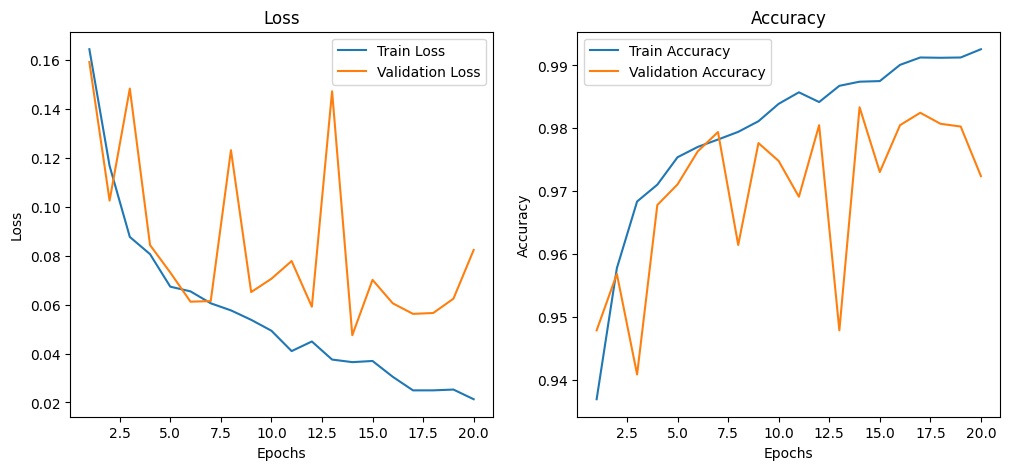

In [10]:
# Plot the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label='Train Loss')
plt.plot(history["epoch"], history["val_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label='Train Accuracy')
plt.plot(history["epoch"], history["val_acc"], label='Validation Accuracy')
# plt.plot(history["epoch"], history["test_acc"], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [11]:
### Download best model

# <a href="/kaggle/working/model_epoch_14.pt"> Download File </a>
# print('test')
from IPython.display import FileLink

!cd /kaggle/working
FileLink(r'model_epoch_14.pt')


/kaggle/working/model_epoch_14.pt

In [12]:
# Test the best model
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ResNet50 model (Architecture)
best_model = models.resnet50()
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 2)

# Load saved weights
best_model.load_state_dict(torch.load('/kaggle/working/model_epoch_14.pt'))

true_labels , predictions = test_model(best_model, test_loader, device)

100%|██████████| 143/143 [01:44<00:00,  1.37it/s]


In [13]:
print(np.array(true_labels).shape)
print(np.array(predictions).shape)

(4565, 2)
(4565,)


In [44]:
true_labels_arr = np.array(torch.max(torch.tensor(true_labels),1)[1])
predictions_arr = np.array(predictions)
true_labels.shape
predictions_arr.shape

(4565,)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2269
           1       0.98      0.98      0.98      2296

    accuracy                           0.98      4565
   macro avg       0.98      0.98      0.98      4565
weighted avg       0.98      0.98      0.98      4565



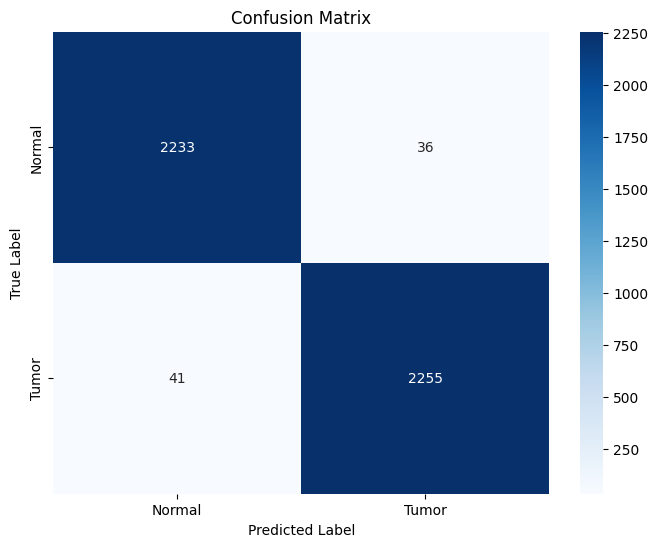

In [46]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions_arr))

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions_arr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()